<a href="https://colab.research.google.com/github/emichester/06MIAR_Aprendizaje_No_Supervisado/blob/main/TrabajoFinal/GANs_condicionales_FashionMNIST_Pr%C3%A1ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta práctica deberéis implementar una GAN condicional con el dataset FashionMNIST.

Podéis basaros en este ejemplo: https://keras.io/examples/generative/conditional_gan/.

Lo único que debéis cambiar es la entrada, tanto del G como del D, para incluir la clase que queréis asociar con la imagen generada.


In [1]:
# montamos la unidad drive donde tenemos los datos en la carpeta drive/My Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
RESULTS_PATH = "/content/results/"
BASE_PATH = "/content/drive/MyDrive/ASIGNATURAS/VIU/06MIAR_Aprendizaje_no_Supervisado/TrabajoFinal/Conditional_GAN"
%mkdir $RESULTS_PATH
%ls $BASE_PATH

cgan_generator_model_001.h5  cgan_generator_model_080.h5  generated_plot_e050.png
cgan_generator_model_010.h5  cgan_generator_model_090.h5  generated_plot_e060.png
cgan_generator_model_020.h5  cgan_generator_model_100.h5  generated_plot_e070.png
cgan_generator_model_030.h5  generated_plot_e001.png      generated_plot_e080.png
cgan_generator_model_040.h5  generated_plot_e010.png      generated_plot_e090.png
cgan_generator_model_050.h5  generated_plot_e020.png      generated_plot_e100.png
cgan_generator_model_060.h5  generated_plot_e030.png      generated_plot_e101.png
cgan_generator_model_070.h5  generated_plot_e040.png


In [30]:
# importamos las librerías necesarias
import numpy as np
import os
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt

In [28]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):
    # En esta ocasión vamos a usar la API funcional de KERAS

    # creamos la entrada de la información condicional
    in_label = Input(shape=(1,))
    # embedding para entradas categóricas
    emb = Embedding(n_classes, 50)(in_label)
    # debemos añadir una capa densa que nos transforme el escalar que representa
    # nuestra clase a una imagen de (28, 28) para luego poder concatenar esa
    # información con la imagen
    n_nodes = in_shape[0] * in_shape[1]
    # mapping_cond_inf = Dense(n_nodes)(in_label)
    mapping_cond_inf = Dense(n_nodes)(emb)
    # canal adicional para las etiquetas
    mapping_cond_inf = Reshape((in_shape[0], in_shape[1], 1))(mapping_cond_inf)

    # entrada de la imagen
    in_image = Input(shape=in_shape)
    # concatenamos la info condicional con la imagen
    merge = Concatenate()([in_image, mapping_cond_inf])
    # downsample
    fe = Conv2D(128, (3, 3), padding='same')(merge)
    fe = MaxPooling2D((2, 2))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3, 3), padding='same')(fe)
    fe = MaxPooling2D((2, 2))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    # definimos y compilamos el modelo (debemos indicarle las dos entradas que
    # va a tener: in_label e in_image)
    model = Model([in_image, in_label], out_layer, name="DISCRIMINATOR")
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [27]:
# definimos el generador
def define_generator(latent_dim, n_classes=10):
    # Aquí también vamos a utilizar la API funcional de Keras

    # creamos la entrada de la información condicional
    in_label = Input(shape=(1,))
    emb = Embedding(n_classes, 50)(in_label)
    n_nodes = 7 * 7
    mapping_cond_inf = Dense(n_nodes)(emb)
    mapping_cond_inf = Reshape((7, 7, 1))(mapping_cond_inf)

    # creamos la entrada de la información condicional
    in_label = Input(shape=(1,))
    # embedding para entradas categóricas
    emb = Embedding(n_classes, 50)(in_label)
    # debemos añadir una capa densa que nos transforme el escalar que representa
    # nuestra clase a una matriz de (N, N) para luego poder concatenar esa
    # información con la imagen
    n_nodes = 7 * 7 # Pista: N*N, donde N debe coincidir con las
    # dimensiones de "gen" más abajo para poder ser concatenado ##
    # mapping_cond_inf = Dense(## Aquí tu código. Pista: número de neuronas ##)(in_label)
    mapping_cond_inf = Dense(n_nodes)(emb)
    mapping_cond_inf = Reshape((7, 7, 1))(mapping_cond_inf)

    # entrada del código latene
    in_lat = Input(shape=(latent_dim,))
    # vamos a mapear nuestro código latente a un espacio bidimensional de mayor
    # número de dimensiones para poder tratar con él con nuestra CNN
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # concatenamos el código latente y la información
    merge = Concatenate()([gen, mapping_cond_inf])
    # aumentamos a 14x14
    gen = Conv2DTranspose(128, (4,4), padding='same')(merge)
    gen = UpSampling2D((2, 2))(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # aumentamos a 28x28
    gen = Conv2DTranspose(128, (4,4), padding='same')(gen)
    gen = UpSampling2D((2, 2))(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # salida del modelo (una imagen en escala de grises de 28x28)
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # definimos el modelo
    model = Model([in_lat, in_label], out_layer, name="GENERATOR")
    model.summary()
    return model

In [26]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):
    # pesos del discriminador congelados
    d_model.trainable = False
    # obtener las entradas de ruido y etiquetas del modelo generador
    gen_noise, gen_label = g_model.input
    # obtener la imagen de salida del modelo generador
    gen_output = g_model.output
    # conectar la salida de imagen y la entrada de etiqueta del generador como entradas al discriminador
    gan_output = d_model([gen_output, gen_label])
    # definir el modelo gan como la toma de ruido y etiqueta y la salida de una clasificación
    model = Model([gen_noise, gen_label], gan_output)
    # compilamos modelo
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [14]:
# definimos las funciones para cargar el MNIST
def load_real_samples():
    # cargamos el dataset - ESTA VEZ QUEREMOS LAS IMÁGENES Y LAS CLASES
    (trainX, trainY), (_, _) = load_data()
    # expandimos la dimensión del batch
    X = np.expand_dims(trainX, axis=-1)
    # convertimos a float32
    X = X.astype('float32')
    # escalamos entre -1 y 1
    X = (X - 127.5) / 127.5
    # devolvemos tanto las imágenes como las clases
    return [X, trainY]

# nos creamos una función que nos devuelva n_samples del dataset (imagen, clase)
# y generamos las etiquetas de entrenamiento GAN: 1
def generate_real_samples(dataset, n_samples):
    # separamos las imágenes de las etiquetas
    images, labels = dataset
    # seleccionamos n_samples muestras aleatoriamente
    ix = np.random.randint(0, images.shape[0], n_samples)
    # las cogemos junto a su correspondiente clase
    X, labels = images[ix], labels[ix]
    # generamos las etiquetas para entrenar la GAN (1)
    y = np.ones((n_samples, 1))
    # debemos devolver, por un lado, X y labels (para condicionar la GAN),
    # y por el otro, la etiqueta que le asignamos: en este caso, al estar
    # entrenando el discriminador, etiqueta = 1
    return [X, labels], y

In [16]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size, n_classes=10):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch
    x_input = np.random.randn(latent_dim * batch_size)
    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    z_input = x_input.reshape(batch_size, latent_dim)
    # generamos clases aleatoriamente: la imagen producida por este código
    # latente y clase deberá ser una imagen realista que pertenezca a dicha
    # clase!
    labels = np.random.randint(0, n_classes, batch_size)
    # debemos devolver tanto el vector de ruido como la "clase": z_input y labels
    return [z_input, labels]

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples):
    # usamos la función anterior para generar los vectores latentes que
    # necesitamos para generar muestras fake acompañados de las clases
    # a las que queremos que pertenezcan las imágenes generadas
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # le introducimos los vectores latentes y las clases al generador para obtener
    # muestras similares a las reales
    images = g_model.predict([z_input, labels_input])
    # le asignamos la etiqueta 0 (porque utilizaremos esta función para
    # entrenar el D)
    y = np.zeros((n_samples,1))
    # debemos devolver, por un lado, images y labels_inputs (para condicionar la GAN),
    # y por el otro, la etiqueta que le asignamos: en este caso, al estar
    # entrenando el generador, etiqueta = 0
    return [images, labels_input], y

In [32]:
# función para guardar las imágenes generadas
def save_plot(examples, epoch, n=10, figsize=(20, 20)):
    examples = (examples * 127.5) + 127.5
    plt.figure(figsize=figsize)
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos las imágenes
    filename = os.path.join(RESULTS_PATH,'generated_plot_e%03d.png' % (epoch+1))
    plt.savefig(filename)
    plt.close()

In [33]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # bucle para las epochs
    for epoch in range(n_epochs):
        # bucle para los batch
        for batch in range(bat_per_epo):

            # en esta ocasión vamos a separar las pérdidas del discriminador
            # cuando le metemos imágenes reales y cuando le metemos imágenes
            # fake para ver cómo lo hace con cada tipo
            # recordad que lo ideal es que llegue a un 50% de acc en cada uno

            # preparamos los datos reales
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # actualizamos el discriminador
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            # generamos datos falsos
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # actualizamos el discriminador
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)

            # preparamos los puntos en el espacio latente: serán la entrada al
            # modelo GAN con el que entrenaremos el generador
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # creamos etiquetas invertidas para el generador: utilizamos el D(x)
            # para que piense que las muestras que le introducimos son reales, y
            # en caso de que diga que no son reales, aprovechamos la información
            # de sus gradientes para actualizar el G(z) para que la próxima vez
            # los datos generados por G(z) sean más plausibles (parecidos a los
            # reales)
            y_gan = np.ones((n_batch, 1))

            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # mostramos el progreso
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (epoch+1, batch+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluamos el desempeño del modelo cada 10 épocas
        if (epoch+1) % 10 == 0 or epoch == 0:
            # preparamos los datos reales
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = d_model.evaluate([X_real, labels_real], y_real, verbose=0)
            # preparamos ejemplos fake
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = d_model.evaluate([X_fake, labels_fake], y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            # guardamos las imágenes generadas
            save_plot(X_fake, epoch)
            # guardamos el generador para tenerlo disponible más tarde
            filename = os.path.join(RESULTS_PATH,'cgan_generator_model_%03d.h5' % (epoch + 1))
            g_model.save(filename)

In [34]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

Model: "DISCRIMINATOR"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 50)                500       ['input_16[0][0]']            
                                                                                                  
 dense_15 (Dense)            (None, 1, 784)               39984     ['embedding_9[0][0]']         
                                                                                                  
 input_17 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                      

In [35]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3)

4/4 [==============================] - 0s 6ms/step
>1, 1/234, d1=0.686, d2=0.703 g=0.682
4/4 [==============================] - 0s 6ms/step
>1, 2/234, d1=0.565, d2=0.738 g=0.653
4/4 [==============================] - 0s 3ms/step
>1, 3/234, d1=0.489, d2=0.787 g=0.626
4/4 [==============================] - 0s 3ms/step
>1, 4/234, d1=0.438, d2=0.811 g=0.621
4/4 [==============================] - 0s 5ms/step
>1, 5/234, d1=0.397, d2=0.804 g=0.658
4/4 [==============================] - 0s 4ms/step
>1, 6/234, d1=0.385, d2=0.753 g=0.713
4/4 [==============================] - 0s 5ms/step
>1, 7/234, d1=0.378, d2=0.681 g=0.778
4/4 [==============================] - 0s 6ms/step
>1, 8/234, d1=0.382, d2=0.615 g=0.864
4/4 [==============================] - 0s 4ms/step
>1, 9/234, d1=0.341, d2=0.549 g=0.951
4/4 [==============================] - 0s 4ms/step
>1, 10/234, d1=0.331, d2=0.494 g=1.042
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d1=0.305, d2=0.436 g=1.153
4/4 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step
>2, 1/234, d1=0.733, d2=0.517 g=1.107
4/4 [==============================] - 0s 4ms/step
>2, 2/234, d1=0.725, d2=0.580 g=1.046
4/4 [==============================] - 0s 4ms/step
>2, 3/234, d1=0.629, d2=0.652 g=0.888
4/4 [==============================] - 0s 5ms/step
>2, 4/234, d1=0.666, d2=0.691 g=0.856
4/4 [==============================] - 0s 4ms/step
>2, 5/234, d1=0.686, d2=0.659 g=0.867
4/4 [==============================] - 0s 4ms/step
>2, 6/234, d1=0.663, d2=0.636 g=0.956
4/4 [==============================] - 0s 5ms/step
>2, 7/234, d1=0.625, d2=0.561 g=1.035
4/4 [==============================] - 0s 4ms/step
>2, 8/234, d1=0.624, d2=0.510 g=1.121
4/4 [==============================] - 0s 5ms/step
>2, 9/234, d1=0.605, d2=0.477 g=1.142
4/4 [==============================] - 0s 4ms/step
>2, 10/234, d1=0.569, d2=0.499 g=1.098
4/4 [==============================] - 0s 5ms/step
>2, 11/234, d1=0.545, d2=0.650 g=0.878
4/4 [==============

No se me guardó el notebook y perdí el notebook ejecutado, pero estuve entrenándolo 100 épocas y tengo los pesos en google Drive. No voy a repetir las horas de ejecución que estuve porque fueron muchas y ya me quedan pocas unidades de ejecución de Google Colab, y también por cuestión de tiempo. Voy a mostrar las imágenes generadas y cargar los pesos.

In [36]:
%ls $RESULTS_PATH # pesos generados por el entrenamiento de 3 épocas anterior

cgan_generator_model_001.h5  generated_plot_e001.png


In [37]:
%ls $BASE_PATH # pesos generados por

cgan_generator_model_001.h5  cgan_generator_model_080.h5  generated_plot_e050.png
cgan_generator_model_010.h5  cgan_generator_model_090.h5  generated_plot_e060.png
cgan_generator_model_020.h5  cgan_generator_model_100.h5  generated_plot_e070.png
cgan_generator_model_030.h5  generated_plot_e001.png      generated_plot_e080.png
cgan_generator_model_040.h5  generated_plot_e010.png      generated_plot_e090.png
cgan_generator_model_050.h5  generated_plot_e020.png      generated_plot_e100.png
cgan_generator_model_060.h5  generated_plot_e030.png      generated_plot_e101.png
cgan_generator_model_070.h5  generated_plot_e040.png


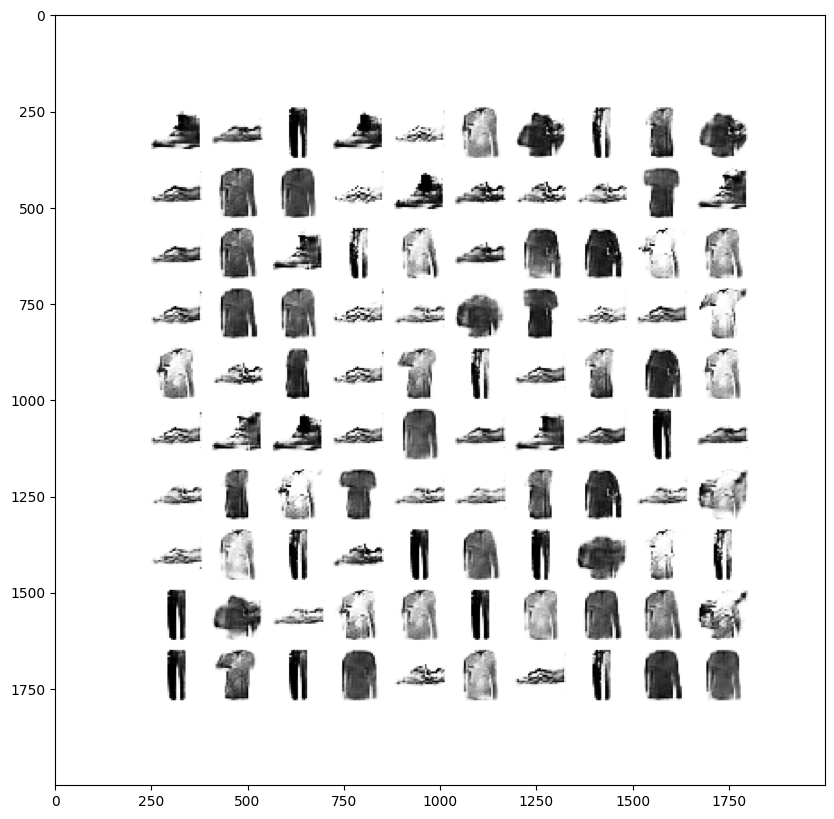

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(BASE_PATH,'generated_plot_e001.png')))
plt.show()

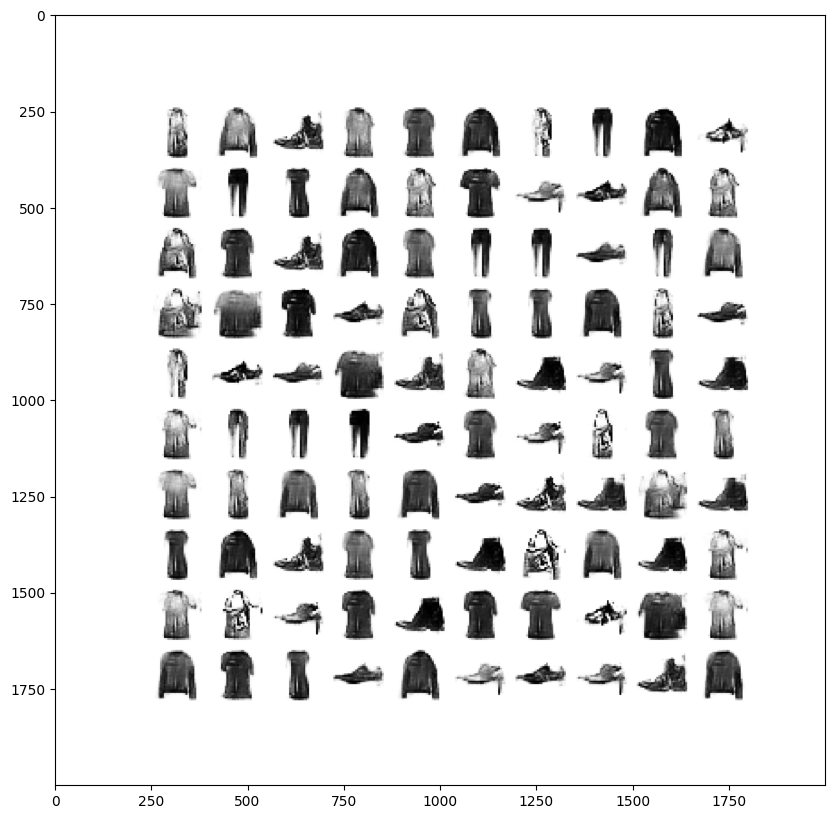

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(BASE_PATH,'generated_plot_e010.png')))
plt.show()

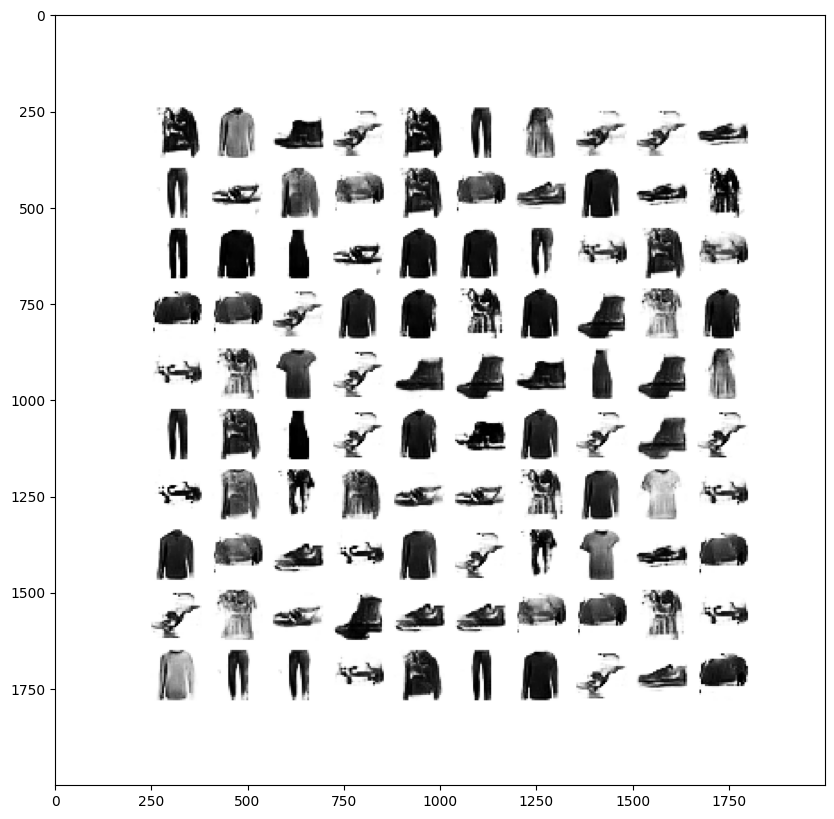

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(BASE_PATH,'generated_plot_e100.png')))
plt.show()

In [51]:
# vamos a generar imágenes de una determinada clase
from tensorflow.keras.models import load_model

# cargamos el modelo
model = load_model(os.path.join(BASE_PATH,'cgan_generator_model_100.h5'))
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 100)

4/4 [==============================] - 0s 5ms/step


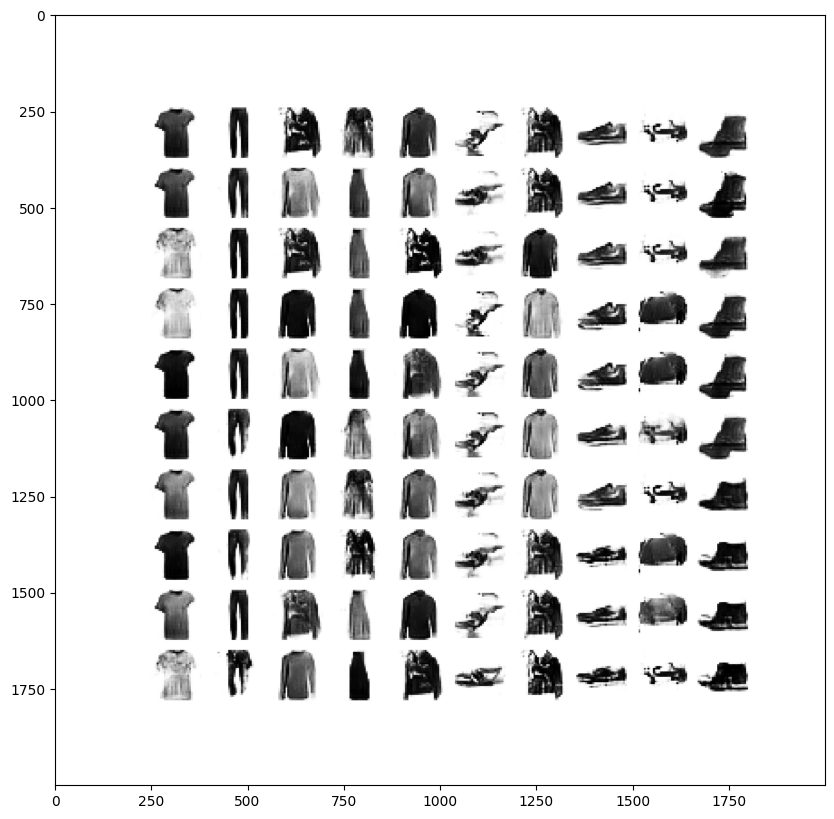

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(RESULTS_PATH,'generated_plot_e101.png')))
plt.show()